In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import warnings; warnings.filterwarnings("ignore")

In [2]:
# change with your path of data_eurec4a dir
path = '/venus/matteo/data_eurec4a/'

In [3]:
GP = np.loadtxt(path + 'data/GP_day_levels.txt')
gph = np.loadtxt(path + 'data/GPH_day_levels.txt')
GPH = gph[:-1]

In [4]:
# PERC and FIXED BIN DISTRIBUTION
path_bindist = path + 'data/perc_dist_daily/anomalies/'
path_fbindist = path + 'data/fb_dist_daily/anomalies/'
path_bindist_fullfield = path + 'data/perc_dist_daily/fullfield/'
path_fbindist_fullfield = path + 'data/fb_dist_daily/fullfield/'

In [5]:
##############
# dU
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dUtot_dsst_day = np.loadtxt(path_bindist + 'pdist_dUtot_dsst_day.txt')
pstd_dUtot_dsst_day = np.loadtxt(path_bindist + 'pstd_dUtot_dsst_day.txt')

In [6]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
dof = 43064  # obtained using dsst_day[::nt,::nskip,::nskip].size
dof = 38367    # obtained usign np.sum(~np.isnan(dsst_day[::nt,::nskip,::nskip]))
doftop = 1826  # obtained using dsst_day[::nttop,::nskiptop,::nskiptop].size
doftop = 1566  # obtained usign np.sum(~np.isnan(dsst_day[::nttop,::nskiptop,::nskiptop]))
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dUtot_dsst_day
s2 = pstd_dUtot_dsst_day**2.
pvalue_dUtot_dsst_day_Lcorr_H = np.zeros(pdist_dUtot_dsst_day.shape)
for h in range(0,pdist_dUtot_dsst_day.shape[0]):
    tstat = m[h]/(np.sqrt(s2[h]/df[h]))
    pvalue_dUtot_dsst_day_Lcorr_H[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dUtot_dsst_day_Lcorr_H[np.isnan(pvalue_dUtot_dsst_day_Lcorr_H)] = 999.

In [7]:
pdist_PBLH_dsst_day = np.loadtxt(path_bindist_fullfield + 'pdist_PBLH_dsst_day.txt')
from metpy.units import units
from metpy.calc import height_to_pressure_std
pdist_P_dsst_day = height_to_pressure_std(pdist_PBLH_dsst_day*units.meter)

In [8]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif_dU = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin_dU = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dUtot_dsst_day_Lcorr_H[h,:-1] > 0.05
    cond2 = np.abs(pdist_dUtot_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dUtot_dsst_day))
#     cond = (cond1) | (cond2)
    cond = cond1
    signif_dU[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif_dU[h, cond] = GPbin[h]
    dsstbin_dU[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [9]:
##############
# dQCLOUD
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dqcloud_dsst_day = np.loadtxt(path_bindist + 'pdist_dQCLOUD_dsst_day.txt')
pstd_dqcloud_dsst_day = np.loadtxt(path_bindist + 'pstd_dQCLOUD_dsst_day.txt')

In [10]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064  # obtained using dsst_day[::nt,::nskip,::nskip].size
dof = 38367    # obtained usign np.sum(~np.isnan(dsst_day[::nt,::nskip,::nskip]))
doftop = 1826  # obtained using dsst_day[::nttop,::nskiptop,::nskiptop].size
doftop = 1566  # obtained usign np.sum(~np.isnan(dsst_day[::nttop,::nskiptop,::nskiptop]))
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dqcloud_dsst_day
s2 = pstd_dqcloud_dsst_day**2.
pvalue_dqcloud_dsst_day_Lcorr = np.zeros(pdist_dqcloud_dsst_day.shape)
for h in range(0,pdist_dqcloud_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dqcloud_dsst_day_Lcorr[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dqcloud_dsst_day_Lcorr[np.isnan(pvalue_dqcloud_dsst_day_Lcorr)] = 999.

In [11]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif_dQCLOUD = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin_dQCLOUD = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dqcloud_dsst_day_Lcorr[h,:-1] > 0.05
    cond2 = np.abs(pdist_dqcloud_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dqcloud_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_dQCLOUD[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif_dQCLOUD[h, cond] = GPbin[h]
    dsstbin_dQCLOUD[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [12]:
##############
# dRH
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_drh_dsst_day = np.loadtxt(path_bindist + 'pdist_dRH_dsst_day.txt')
pstd_drh_dsst_day = np.loadtxt(path_bindist + 'pstd_dRH_dsst_day.txt')

In [13]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064  # obtained using dsst_day[::nt,::nskip,::nskip].size
dof = 38367    # obtained usign np.sum(~np.isnan(dsst_day[::nt,::nskip,::nskip]))
doftop = 1826  # obtained using dsst_day[::nttop,::nskiptop,::nskiptop].size
doftop = 1566  # obtained usign np.sum(~np.isnan(dsst_day[::nttop,::nskiptop,::nskiptop]))
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_drh_dsst_day
s2 = pstd_drh_dsst_day**2.
pvalue_drh_dsst_day = np.zeros(pdist_drh_dsst_day.shape)
for h in range(0,pdist_drh_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_drh_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_drh_dsst_day[np.isnan(pvalue_drh_dsst_day)] = 999.

In [14]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif_dRH = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin_dRH = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_drh_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(pdist_drh_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_drh_dsst_day))
    cond = (cond1) | (cond2)
    signif_dRH[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif_dRH[h, cond] = GPbin[h]
    dsstbin_dRH[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

In [15]:
##############
# dN2 Brunt Vaisala
pdist_dsst_day = np.loadtxt(path_bindist + 'pdist_dsst_day.txt')
pdist_dN2_dsst_day = np.loadtxt(path_bindist + 'pdist_dN2_dsst_day.txt')
pstd_dN2_dsst_day = np.loadtxt(path_bindist + 'pstd_dN2_dsst_day.txt')

In [16]:
# compute P VALUE from mean and std
# corr time 1 day 
# corr length 30km up to level 27
# corr length 150km from level 28 upwards
popmean = 0.
dof = 43064  # obtained using dsst_day[::nt,::nskip,::nskip].size
dof = 38367    # obtained usign np.sum(~np.isnan(dsst_day[::nt,::nskip,::nskip]))
doftop = 1826  # obtained using dsst_day[::nttop,::nskiptop,::nskiptop].size
doftop = 1566  # obtained usign np.sum(~np.isnan(dsst_day[::nttop,::nskiptop,::nskiptop]))
df = np.append(np.repeat(dof, 27), np.repeat(doftop, 74-27))
m = pdist_dN2_dsst_day
s2 = pstd_dN2_dsst_day**2.
pvalue_dN2_dsst_day = np.zeros(pdist_dN2_dsst_day.shape)
for h in range(0,pdist_dN2_dsst_day.shape[0]):
    tstat = (m[h]-popmean)/(np.sqrt(s2[h]/df[h]))
    pvalue_dN2_dsst_day[h] = 2*(1 - stats.t.cdf(np.abs(tstat), df=df[h]-1))
# set nan values of pvalue as 999.
pvalue_dN2_dsst_day[np.isnan(pvalue_dN2_dsst_day)] = 999.

In [17]:
# DEF punti significativi (pvalue < 0.05)
GPbin = GP[1:] - np.diff(GP)*0.5
signif_dN2 = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
dsstbin_dN2 = np.zeros((len(GP)-1,len(pdist_dsst_day)-1))
for h in range(0,len(GP)-1):
    cond1 = pvalue_dN2_dsst_day[h,:-1] > 0.05
    cond2 = np.abs(pdist_dN2_dsst_day[h,:-1]) < 0.1*np.nanmean(np.abs(pdist_dN2_dsst_day))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_dN2[h,:] = np.zeros(len(pdist_dsst_day)-1) + np.nan
    signif_dN2[h, cond] = GPbin[h]
    dsstbin_dN2[h,:] = pdist_dsst_day[1:] - np.diff(pdist_dsst_day)*0.5

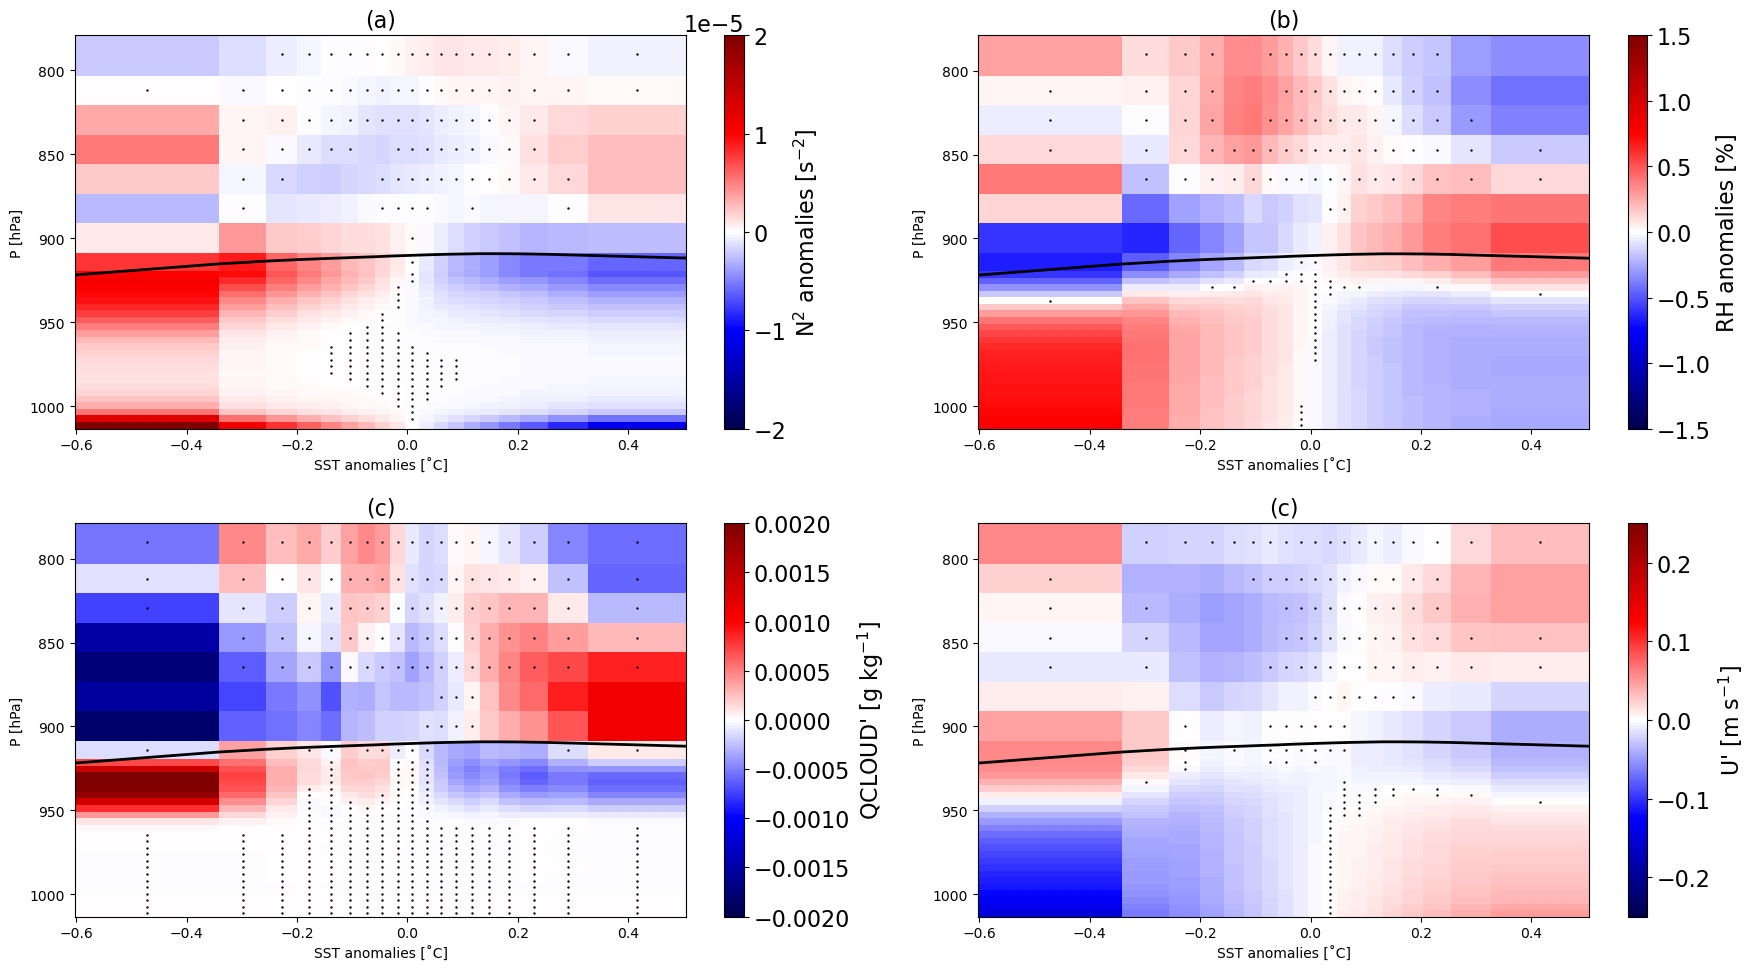

In [18]:
fig, axs = plt.subplots(2,2, figsize=(18, 10))

plt.rcParams.update({'font.size': 16})

level = 33

# dN2
ax = axs[0,0]
pc = ax.pcolormesh(pdist_dsst_day, GP[:level], pdist_dN2_dsst_day[:level], vmin=-2.e-5, vmax=2.e-5, cmap='seismic')
ax.invert_yaxis()
ax.set_title('(a)', fontsize=16)
ax.set_xlabel('SST anomalies [˚C]'); ax.set_ylabel('P [hPa]')
cbar = plt.colorbar(pc, ax=ax); cbar.set_label('N$^2$ anomalies [s$^{-2}$]')

ax.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
ax.scatter(dsstbin_dN2[:level-1], signif_dN2[:level-1],  s=0.5, color='k')

# dRH
ax = axs[0,1]
pc = ax.pcolormesh(pdist_dsst_day, GP[:level], pdist_drh_dsst_day[:level], vmin=-1.5, vmax=1.5, cmap='seismic')
ax.invert_yaxis()
ax.set_title('(b)', fontsize=16)
ax.set_xlabel('SST anomalies [˚C]'); ax.set_ylabel('P [hPa]')
cbar = plt.colorbar(pc, ax=ax); cbar.set_label('RH anomalies [%]')

ax.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
ax.scatter(dsstbin_dRH[:level-1], signif_dRH[:level-1],  s=0.5, color='k')

# dQCLOUD
ax = axs[1,0]
pc = ax.pcolormesh(pdist_dsst_day, GP[:level], pdist_dqcloud_dsst_day[:level], vmin=-2e-3, vmax=2.e-3, cmap='seismic')
ax.invert_yaxis()
ax.set_title('(c)', fontsize=16)
ax.set_xlabel('SST anomalies [˚C]'); ax.set_ylabel('P [hPa]')
cbar = plt.colorbar(pc, ax=ax);  cbar.set_label("QCLOUD' [g kg$^{-1}$]")

ax.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
ax.scatter(dsstbin_dQCLOUD[:level-1], signif_dQCLOUD[:level-1],  s=0.5, color='k')

# dU
ax = axs[1,1]
pc = ax.pcolormesh(pdist_dsst_day, GP[:level], pdist_dUtot_dsst_day[:level], vmin=-0.25, vmax=0.25, cmap='seismic')
ax.invert_yaxis()
ax.set_title('(c)', fontsize=16)
ax.set_xlabel('SST anomalies [˚C]'); ax.set_ylabel('P [hPa]')
cbar = plt.colorbar(pc, ax=ax);  cbar.set_label("U' [m s$^{-1}$]")

ax.plot(pdist_dsst_day, pdist_P_dsst_day, '-', color='k', linewidth=2)
ax.scatter(dsstbin_dU[:level-1], signif_dU[:level-1],  s=0.5, color='k')

fig.tight_layout()